### Action1
二手车价格预测
used_car_train_20200313.csv
used_car_testB_20200421.csv
数据来自某交易平台的二手车交易记录
https://tianchi.aliyun.com/competition/entrance/231784/introduction
ToDo：给你一辆车的各个属性（除了price字段），预测它的价格
使用神经网络来完成预测

In [10]:
import warnings
warnings.filterwarnings('ignore')

# 载入数据
import pandas as pd
train_data = pd.read_csv('./used_car_train_20200313.csv', sep=' ')
test_data = pd.read_csv('./used_car_testB_20200421.csv', sep=' ')
print('train_data shape:', train_data.shape)
print('test_data shape:', test_data.shape)
train_data.head()

train_data shape: (150000, 31)
test_data shape: (50000, 30)


,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [2]:
import numpy as np 
print(np.min(train_data['regDate']))
print(np.min(test_data['regDate']))
print(np.min(train_data['creatDate']))
print(np.min(test_data['creatDate']))

19910001
19910001
20150618
20140310


In [2]:
# 对时间数据regDate（车主买车注册的时间）和creatDate（汽车再次上线售卖的时间）进行处理（时间Diff）
min_date = pd.to_datetime('19910101', format='%Y%m%d')

train_data['regTime'] = (pd.to_datetime(train_data['regDate'], format='%Y%m%d', errors='coerce') - min_date).dt.days
test_data['regTime'] = (pd.to_datetime(test_data['regDate'], format='%Y%m%d', errors='coerce') - min_date).dt.days

train_data['creatTime'] = (pd.to_datetime(train_data['creatDate'], format='%Y%m%d', errors='coerce') - min_date).dt.days
test_data['creatTime'] = (pd.to_datetime(test_data['creatDate'], format='%Y%m%d', errors='coerce') - min_date).dt.days

# 对redDate和creatDate作差，得到一列新的值作为车主的使用时间
train_data['usedTime'] = train_data['creatTime'] - train_data['regTime']
test_data['usedTime'] = test_data['creatTime'] - test_data['regTime']

#### 缺失值填补

In [4]:
print(train_data.info())
print(train_data.isnull().sum())
print('-'*30)
print(test_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 34 columns):
SaleID               150000 non-null int64
name                 150000 non-null int64
regDate              150000 non-null int64
model                149999 non-null float64
brand                150000 non-null int64
bodyType             145494 non-null float64
fuelType             141320 non-null float64
gearbox              144019 non-null float64
power                150000 non-null int64
kilometer            150000 non-null float64
notRepairedDamage    150000 non-null object
regionCode           150000 non-null int64
seller               150000 non-null int64
offerType            150000 non-null int64
creatDate            150000 non-null int64
price                150000 non-null int64
v_0                  150000 non-null float64
v_1                  150000 non-null float64
v_2                  150000 non-null float64
v_3                  150000 non-null float64
v_4       

##### 缺失较少且分布明显的用众数填补

In [5]:
print(train_data['model'].value_counts())
print(train_data['bodyType'].value_counts())
print(train_data['fuelType'].value_counts())
print(train_data['gearbox'].value_counts())
print('-'*30)
print(test_data['bodyType'].value_counts())
print(test_data['fuelType'].value_counts())
print(test_data['gearbox'].value_counts())

0.0      11762
19.0      9573
4.0       8445
1.0       6038
29.0      5186
48.0      5052
40.0      4502
26.0      4496
8.0       4391
31.0      3827
13.0      3762
17.0      3121
65.0      2730
49.0      2608
46.0      2454
30.0      2342
44.0      2195
5.0       2063
10.0      2004
21.0      1872
73.0      1789
11.0      1775
23.0      1696
22.0      1524
69.0      1522
63.0      1469
7.0       1460
16.0      1349
88.0      1309
66.0      1250
         ...  
141.0       37
133.0       35
216.0       30
202.0       28
151.0       26
226.0       26
231.0       23
234.0       23
233.0       20
198.0       18
224.0       18
227.0       17
237.0       17
220.0       16
230.0       16
239.0       14
223.0       13
236.0       11
241.0       10
232.0       10
229.0       10
235.0        7
246.0        7
243.0        4
244.0        3
245.0        2
209.0        2
240.0        2
242.0        2
247.0        1
Name: model, Length: 248, dtype: int64
0.0    41420
1.0    35272
2.0    30324
3.0    

In [3]:
train_data['model'].fillna(0.0, inplace=True)
train_data['bodyType'].fillna(0.0, inplace=True)
train_data['fuelType'].fillna(0.0, inplace=True)
train_data['gearbox'].fillna(0.0, inplace=True)

test_data['bodyType'].fillna(0.0, inplace=True)
test_data['fuelType'].fillna(0.0, inplace=True)
test_data['gearbox'].fillna(0.0, inplace=True)

##### 对异常字段进行处理

In [8]:
print(train_data['power'].describe())
print(test_data['power'].describe())

count    150000.000000
mean        119.316547
std         177.168419
min           0.000000
25%          75.000000
50%         110.000000
75%         150.000000
max       19312.000000
Name: power, dtype: float64
count    50000.000000
mean       119.766960
std        206.313348
min          0.000000
25%         75.000000
50%        110.000000
75%        150.000000
max      19211.000000
Name: power, dtype: float64


In [4]:
train_data['power'][train_data['power']>600] = 600
test_data['power'][test_data['power']>600] = 600

##### 根据corr选择feature

In [11]:
temp = train_data.copy()
temp['notRepairedDamage'] = train_data['notRepairedDamage'].replace('-', '1.0').astype('float64')
temp['regTime'] = train_data['regTime'].fillna(np.mean(train_data['regTime']))
temp['usedTime'] = train_data['usedTime'].fillna(np.mean(train_data['usedTime']))
# temp.info()
temp.corr()['price']

SaleID              -0.001043
name                 0.002030
regDate              0.611959
model                0.136933
brand               -0.043799
bodyType             0.248609
fuelType             0.209510
gearbox              0.330353
power                0.556400
kilometer           -0.440519
notRepairedDamage   -0.239071
regionCode           0.014036
seller              -0.002004
offerType                 NaN
creatDate            0.002955
price                1.000000
v_0                  0.628397
v_1                  0.060914
v_2                  0.085322
v_3                 -0.730946
v_4                 -0.147085
v_5                  0.164317
v_6                  0.068970
v_7                 -0.053024
v_8                  0.685798
v_9                 -0.206205
v_10                -0.246175
v_11                -0.275320
v_12                 0.692823
v_13                -0.013993
v_14                 0.035911
regTime              0.598475
creatTime            0.016916
usedTime  

In [8]:
train_data['offerType'].value_counts()

0    150000
Name: offerType, dtype: int64

In [5]:
features = [col for col in train_data.columns if col not in ['SaleID', 'name',  'seller', 'offerType', 'creatDate', 'price']]
train = train_data[features]
test = test_data[features]

##### 其余用BayesianRidge填补

In [14]:
print(train['notRepairedDamage'].value_counts())
print(test['notRepairedDamage'].value_counts())

0.0    111361
-       24324
1.0     14315
Name: notRepairedDamage, dtype: int64
0.0    37224
-       8069
1.0     4707
Name: notRepairedDamage, dtype: int64


In [6]:
import numpy as np
train['notRepairedDamage'].replace('-', np.nan, inplace=True)
test['notRepairedDamage'].replace('-', np.nan, inplace=True)
train.loc[:,'notRepairedDamage'] = train.loc[:,'notRepairedDamage'].astype('float64')
test.loc[:,'notRepairedDamage'] = test.loc[:,'notRepairedDamage'].astype('float64')

from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer(random_state=0)
# imputer = KNNImputer(n_neighbors=3, weights='distance')
train = imputer.fit_transform(train)
test = imputer.transform(test)

In [7]:
# local(防止标签泄露重新进行填充)
import numpy as np
train_Y = train_data['price']
train_X = train_data[features]
train_X['notRepairedDamage'].replace('-', np.nan, inplace=True)
train_X.loc[:,'notRepairedDamage'] = train_X.loc[:,'notRepairedDamage'].astype('float64')

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
train_x, val_x, train_y, val_y = train_test_split(train_X, train_Y, test_size=0.2, random_state=0)
imputer = IterativeImputer(random_state=0)
# imputer = KNNImputer(n_neighbors=3, weights='distance')

train_x = imputer.fit_transform(train_x)
val_x = imputer.transform(val_x)

#### 模型定义

##### XGBoost/LightGBM

In [8]:
# 模型定义
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import lightgbm as lgb

# def build_model_xgb(x_train, y_train):
#     learning_rates = [0.01, 0.05, 0.1]
#     param_grid = dict(learning_rate = learning_rates)
#     model = xgb.XGBRegressor(n_estimators=500, max_depth=7)
#     grid_cv = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', n_jobs=-1)
#     grid_cv.fit(x_train, y_train)
#     return grid_cv

def build_model_xgb(x_train, y_train):
    model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=7)
    model.fit(x_train, y_train)
    return model

def build_model_lgb(x_train, y_train):
    learning_rates = [0.01, 0.05, 0.1, 0.2]
    param_grid = dict(learning_rate = learning_rates)
    model = lgb.LGBMRegressor(n_estimators=500, num_leaves=127)
    grid_cv = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_cv.fit(x_train, y_train)
    return grid_cv

# def build_model_lgb(x_train, y_train):
#     model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.1, max_depth=7)
#     model.fit(x_train, y_train)
#     return model

##### 神经网络

In [14]:
# 载入数据
import pandas as pd
import numpy as np
train_data = pd.read_csv('./used_car_train_20200313.csv', sep=' ')
test_data = pd.read_csv('./used_car_testB_20200421.csv', sep=' ')

# 数据预处理
train_data['notRepairedDamage'].replace('-', np.nan, inplace=True)
test_data['notRepairedDamage'].replace('-', np.nan, inplace=True)
train_data['notRepairedDamage'] = train_data['notRepairedDamage'].astype('float64')
test_data['notRepairedDamage'] = test_data['notRepairedDamage'].astype('float64')
train_data.fillna(train_data.median(), inplace=True)
test_data.fillna(test_data.median(), inplace=True) # 中位数填补
train_data['power'][train_data['power']>600] = 600
test_data['power'][test_data['power']>600] = 600

features = [col for col in train_data.columns if col not in ['SaleID', 'name',  'seller', 'offerType', 'creatDate', 'price']]
train = train_data[features]
test = test_data[features]
y = train_data['price']

from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(train, y, test_size=0.2, random_state=0)

from sklearn.preprocessing import MinMaxScaler, StandardScaler
mm = MinMaxScaler()
# ss = StandardScaler()

mm_train = mm.fit_transform(train)
mm_test = mm.transform(test)
# ss_train = ss.fit_transform(train)
# ss_test = ss.transform(test)

mm_train_x = mm.fit_transform(train_x)
mm_val_x = mm.transform(val_x)
# ss_train_x = mm.fit_transform(train_x)
# ss_val_x = mm.transform(val_x)

In [15]:
import keras
def build_network(x_train, y_train):
    network = keras.Sequential([
        keras.layers.Dense(300, activation='relu', input_shape=[len(features)]),
        keras.layers.Dense(300, activation='relu'),
#         keras.layers.Dropout(0.02),
        keras.layers.Dense(200, activation='relu'),
        keras.layers.Dense(1)
    ])
    
    network.compile(loss='mean_absolute_error', optimizer='Adam')
    network.fit(x_train, y_train, batch_size=1024, epochs=200)
    return network

#### 模型训练

In [6]:
def show_stats(data):
    print('min:', np.min(data))
    print('max:', np.max(data))
    print('ptp:', np.ptp(data))
    print('mean:', np.mean(data))
    print('std:', np.std(data))
    print('var:', np.var(data))

##### 对于测试集

In [10]:
from sklearn.metrics import mean_absolute_error

model0_xgb = build_model_xgb(train_x, train_y)
pred0_xgb = model0_xgb.predict(val_x)
MAE_xgb = mean_absolute_error(pred0_xgb, val_y)
print('XGB validation MAE:', MAE_xgb)

model0_lgb = build_model_lgb(train_x, train_y)
pred0_lgb = model0_lgb.predict(val_x)
MAE_lgb = mean_absolute_error(pred0_lgb, val_y)
print('best learning_rate in the grid:', model0_lgb.get_params()['estimator__learning_rate'])
print('LGBM validation MAE:', MAE_lgb)

XGB validation MAE: 556.8437162533919
best learning_rate in the grid: 0.1
LGBM validation MAE: 547.0415297001203


In [16]:
network0 = build_network(mm_train_x, train_y)
pred0_net = network0.predict(mm_val_x)
MAE_net = mean_absolute_error(pred0_net, val_y)
print('network validation MAE:', MAE_net)

Epoch 1/200
118/118 [==============================] - 0s 4ms/step - loss: 4860.6348
Epoch 2/200
118/118 [==============================] - 0s 4ms/step - loss: 2697.7109
Epoch 3/200
118/118 [==============================] - 1s 4ms/step - loss: 1271.9254
Epoch 4/200
118/118 [==============================] - 1s 5ms/step - loss: 1077.8231
Epoch 5/200
118/118 [==============================] - 1s 5ms/step - loss: 993.0881
Epoch 6/200
118/118 [==============================] - 1s 4ms/step - loss: 929.8821
Epoch 7/200
118/118 [==============================] - 0s 4ms/step - loss: 883.1588
Epoch 8/200
118/118 [==============================] - 1s 5ms/step - loss: 844.2262
Epoch 9/200
118/118 [==============================] - 1s 5ms/step - loss: 815.6726
Epoch 10/200
118/118 [==============================] - 1s 5ms/step - loss: 786.3279
Epoch 11/200
118/118 [==============================] - 1s 5ms/step - loss: 761.1639
Epoch 12/200
118/118 [==============================] - 0s 4ms/step - 

##### 对于原数据

In [11]:
y = train_data['price']
show_stats(y)
print('-'*30)

model1_xgb = build_model_xgb(train, y)
result_xgb = model1_xgb.predict(test)
show_stats(result_xgb)
print('-'*30)

model1_lgb = build_model_lgb(train, y)
result_lgb = model1_lgb.predict(test)
show_stats(result_lgb)

min: 11
max: 99999
ptp: 99988
mean: 5923.327333333334
std: 7501.973469876635
var: 56279605.942732885
------------------------------
min: -584.0093
max: 90166.86
ptp: 90750.87
mean: 5910.7524
std: 7366.219
var: 54261188.0
------------------------------
min: -595.0759479259906
max: 92738.33256704069
ptp: 93333.40851496668
mean: 5912.592765967055
std: 7390.865671536651
var: 54624895.3746989


In [18]:
model1_net = build_network(mm_train, y)
result_net = model1_net.predict(mm_test)
show_stats(result_net)

Epoch 1/200
147/147 [==============================] - 1s 4ms/step - loss: 4581.2778
Epoch 2/200
147/147 [==============================] - 1s 4ms/step - loss: 1779.5054
Epoch 3/200
147/147 [==============================] - 1s 4ms/step - loss: 1097.3287
Epoch 4/200
147/147 [==============================] - 1s 4ms/step - loss: 974.5061
Epoch 5/200
147/147 [==============================] - 1s 4ms/step - loss: 897.8413
Epoch 6/200
147/147 [==============================] - 1s 4ms/step - loss: 840.4758
Epoch 7/200
147/147 [==============================] - 1s 5ms/step - loss: 798.0227
Epoch 8/200
147/147 [==============================] - 1s 4ms/step - loss: 763.0831
Epoch 9/200
147/147 [==============================] - 1s 4ms/step - loss: 733.4302
Epoch 10/200
147/147 [==============================] - 1s 4ms/step - loss: 707.9447
Epoch 11/200
147/147 [==============================] - 1s 4ms/step - loss: 684.7103
Epoch 12/200
147/147 [==============================] - 1s 4ms/step - l

##### 输出结果

In [12]:
# 输出XGB结果
result = pd.DataFrame()
result['SaleID'] = test_data['SaleID']
result['price'] = result_xgb
result['price'][result['price']<11] = 11
result.to_csv('./ans_xgb_03.csv', index=False)

In [13]:
# 输出LGBM结果
result1 = pd.DataFrame()
result1['SaleID'] = test_data['SaleID']
result1['price'] = result_lgb
result1['price'][result1['price']<11] = 11
result1.to_csv('./ans_lgb_02.csv', index=False)

In [19]:
# 输出network结果
result2 = pd.DataFrame()
result2['SaleID'] = test_data['SaleID']
result2['price'] = result_net
result2['price'][result2['price']<11] = 11
result2.to_csv('./ans_net_02.csv', index=False)

In [64]:
# 输出模型加权结果
predict_y = (1-MAE_lgb/(MAE_lgb+MAE_xgb))*result_lgb + (1-MAE_xgb/(MAE_lgb+MAE_xgb))*result_xgb
print('XGB weight:', 1-MAE_xgb/(MAE_lgb+MAE_xgb))
print('LGBM weight:', 1-MAE_lgb/(MAE_lgb+MAE_xgb))
show_stats(predict_y)
result_plus = pd.DataFrame()
result_plus['SaleID'] = test_data['SaleID']
result_plus['price'] = predict_y
result_plus['price'][result_plus['price']<11] = 11
result_plus.to_csv('./ans_xgb+lgb_01.csv', index=False)

XGB weight: 0.5009656427067725
LGBM weight: 0.49903435729322765
min: -526.5105754463781
max: 90901.90552209488
ptp: 91428.41609754125
mean: 5909.322666807252
std: 7367.337816611392
var: 54277666.5040723


In [1]:
MAE_xgb = 556.8437162533919
MAE_lgb = 547.0415297001203
MAE_net = 491.74106881175834

In [8]:
import pandas as pd
import numpy as np
ans_xgb = pd.read_csv('./ans_xgb_03.csv')
ans_lgb = pd.read_csv('./ans_lgb_02.csv')
ans_net = pd.read_csv('./ans_net_02.csv')
result_xgb = ans_xgb['price'].values
result_lgb = ans_lgb['price'].values
result_net = ans_net['price'].values

In [11]:
# 输出模型加权结果
predict_y = (1-MAE_lgb/(MAE_lgb+MAE_net))*result_lgb + (1-MAE_net/(MAE_lgb+MAE_net))*result_net
print('network weight:', 1-MAE_net/(MAE_lgb+MAE_net))
print('LGBM weight:', 1-MAE_lgb/(MAE_lgb+MAE_xgb))
show_stats(predict_y)
result_plus = pd.DataFrame()
result_plus['SaleID'] = test_data['SaleID']
result_plus['price'] = predict_y
result_plus['price'][result_plus['price']<11] = 11
result_plus.to_csv('./ans_lgb+net_01.csv', index=False)

network weight: 0.5266179184015902
LGBM weight: 0.5044398575799447
min: 17.052997436045963
max: 95026.77307741149
ptp: 95009.72007997545
mean: 5891.423401913958
std: 7373.217569279748
var: 54364337.32393555


In [12]:
# 输出模型加权结果
predict_y = (2/3-MAE_lgb/(MAE_lgb+MAE_xgb+MAE_net))*result_lgb + (2/3-MAE_xgb/(MAE_lgb+MAE_xgb+MAE_net))*result_xgb + (2/3-MAE_net/(MAE_lgb+MAE_xgb+MAE_net))*result_net
print('XGB weight:', 2/3-MAE_lgb/(MAE_lgb+MAE_xgb+MAE_net))
print('LGBM weight:', 2/3-MAE_lgb/(MAE_lgb+MAE_xgb+MAE_net))
print('network weight:', 2/3-MAE_net/(MAE_lgb+MAE_xgb+MAE_net))
show_stats(predict_y)
result_plus = pd.DataFrame()
result_plus['SaleID'] = test_data['SaleID']
result_plus['price'] = predict_y
result_plus['price'][result_plus['price']<11] = 11
result_plus.to_csv('./ans_xgb+lgb+net_01.csv', index=False)

XGB weight: 0.3238285443331211
LGBM weight: 0.3238285443331211
network weight: 0.3584860705826159
min: 19.30229003930468
max: 93479.22974568835
ptp: 93459.92745564904
mean: 5897.636763259285
std: 7366.55699383354
var: 54266161.94339785


LGBM+nn的提交结果最好，结果如下：  
![LGBM+nn](./ans_lgb+net_01.png)

### Action2
智能供应链分析
数据集：SupplyChainDataset.csv，供应链采购数据
To Do：
供应链数据探索

In [2]:
import pandas as pd

# 数据加载
data = pd.read_csv('./SupplyChain.csv', encoding='unicode_escape')
print(data.shape)
data.head()

(180519, 53)


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


#### 数据探索

In [3]:
# 查看缺失值
temp = data.isnull().sum()
temp[temp>0]

Customer Lname              8
Customer Zipcode            3
Order Zipcode          155679
Product Description    180519
dtype: int64

In [141]:
# 对缺失较少的用众数填补
print(data['Customer Zipcode'].value_counts().head())
print(data['Customer Lname'].value_counts().head())

725.0      66773
921.0        337
23455.0      334
957.0        297
79109.0      292
Name: Customer Zipcode, dtype: int64
Smith       64104
Johnson       989
Brown         909
Williams      869
Jones         859
Name: Customer Lname, dtype: int64


In [142]:
data['Customer Zipcode'] = data['Customer Zipcode'].fillna(725.0)
data['Customer Lname'] = data['Customer Lname'].fillna('Smith')

In [15]:
# 查看最常出现的顾客姓名（top10）
data['Customer Name'] = data['Customer Fname'] + ' ' + data['Customer Lname']
data[['Customer Name', 'Customer Fname', 'Customer Lname']] 

,Customer Name,Customer Fname,Customer Lname
0,Cally Holloway,Cally,Holloway
1,Irene Luna,Irene,Luna
2,Gillian Maldonado,Gillian,Maldonado
3,Tana Tate,Tana,Tate
4,Orli Hendricks,Orli,Hendricks
5,Kimberly Flowers,Kimberly,Flowers
6,Constance Terrell,Constance,Terrell
7,Erica Stevens,Erica,Stevens
8,Nichole Olsen,Nichole,Olsen
9,Oprah Delacruz,Oprah,Delacruz


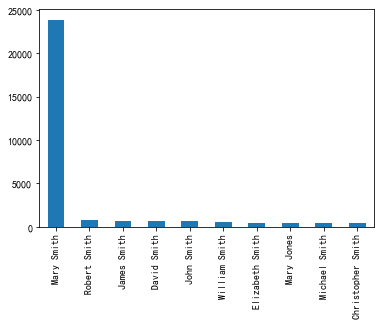

In [146]:
data['Customer Name'].value_counts().head(10).plot.bar()
plt.show()

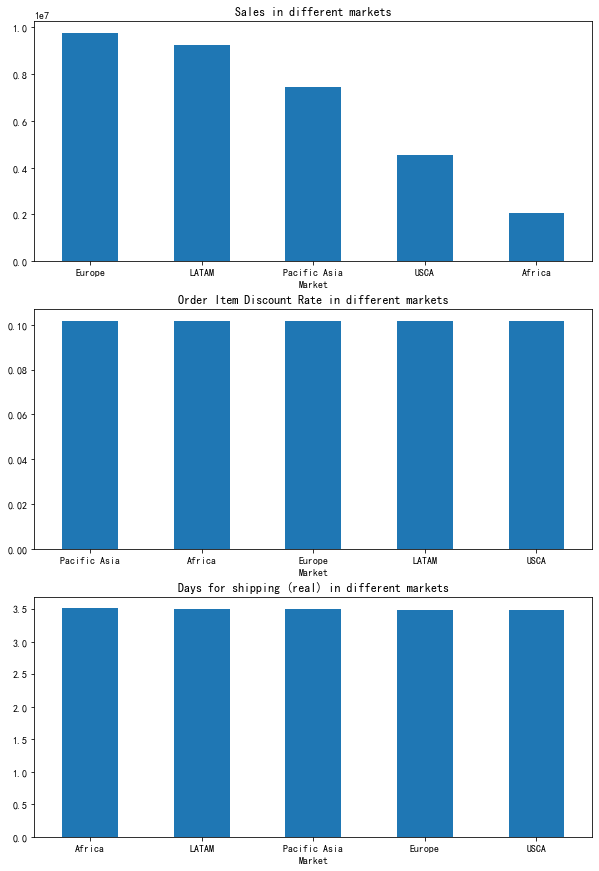

In [51]:
# 基于Market查看销售总额，平均折扣率，平均送货时间
import matplotlib.pyplot as plt

# plt.rcParams['font.sans-serif']=['SimHei'] # 正常显示中文
market = data.groupby('Market')
plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
market['Sales per customer'].sum().sort_values(ascending=False).plot.bar(title='Sales in different markets')
plt.xticks(rotation=0, fontsize=10) # 标签横向显示
plt.subplot(3,1,2)
market['Order Item Discount Rate'].mean().sort_values(ascending=False).plot.bar(title='Order Item Discount Rate in different markets')
plt.xticks(rotation=0, fontsize=10)
plt.subplot(3,1,3)
market['Days for shipping (real)'].mean().sort_values(ascending=False).plot.bar(title='Days for shipping (real) in different markets')
plt.xticks(rotation=0, fontsize=10)
plt.show()

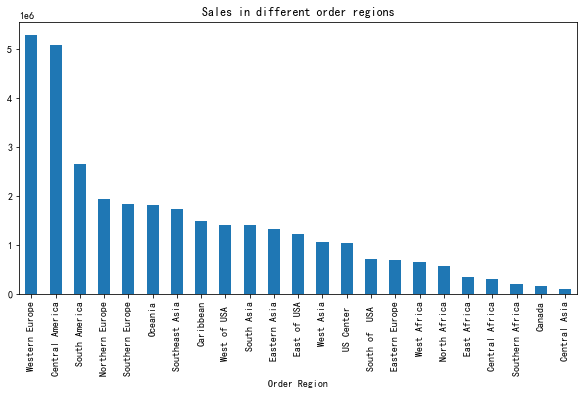

In [46]:
# 对于不同Order Region查看总销售额
region = data.groupby('Order Region')
plt.figure(figsize=(10,5))
region['Sales per customer'].sum().sort_values(ascending=False).plot.bar(title='Sales in different order regions')
plt.show()

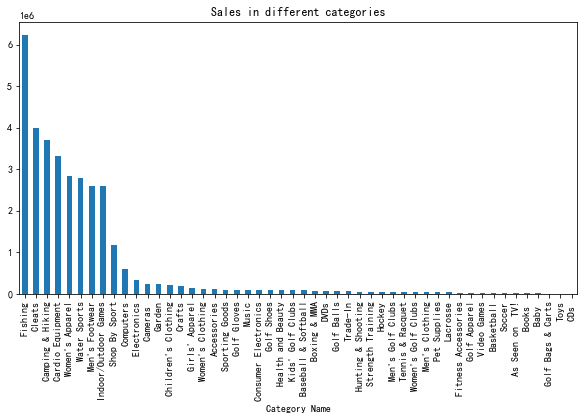

In [45]:
# 对于不同Category查看总销售额
cat = data.groupby('Category Name')
plt.figure(figsize=(10,5))
cat['Sales per customer'].sum().sort_values(ascending=False).plot.bar(title='Sales in different categories')
plt.show()

In [81]:
# 基于不同的时间维度（年，月，星期，小时）
temp = pd.DatetimeIndex(data['order date (DateOrders)'])
temp

DatetimeIndex(['2018-01-31 22:56:00', '2018-01-13 12:27:00',
               '2018-01-13 12:06:00', '2018-01-13 11:45:00',
               '2018-01-13 11:24:00', '2018-01-13 11:03:00',
               '2018-01-13 10:42:00', '2018-01-13 10:21:00',
               '2018-01-13 10:00:00', '2018-01-13 09:39:00',
               ...
               '2016-01-16 06:49:00', '2016-01-16 06:49:00',
               '2016-01-16 06:28:00', '2016-01-16 06:07:00',
               '2016-01-16 05:04:00', '2016-01-16 03:40:00',
               '2016-01-16 01:34:00', '2016-01-15 21:00:00',
               '2016-01-15 20:18:00', '2016-01-15 18:54:00'],
              dtype='datetime64[ns]', name='order date (DateOrders)', length=180519, freq=None)

In [82]:
data['order_year'] = temp.year.astype('int')
data['order_month'] = temp.month
data['order_week_day'] = temp.weekday
data['order_hour'] = temp.hour
data['order_month_year'] = temp.to_period('M')
data[['order_year', 'order_month', 'order_week_day', 'order_hour', 'order_month_year']].head()

,order_year,order_month,order_week_day,order_hour,order_month_year
0,2018,1,2,22,2018-01
1,2018,1,5,12,2018-01
2,2018,1,5,12,2018-01
3,2018,1,5,11,2018-01
4,2018,1,5,11,2018-01


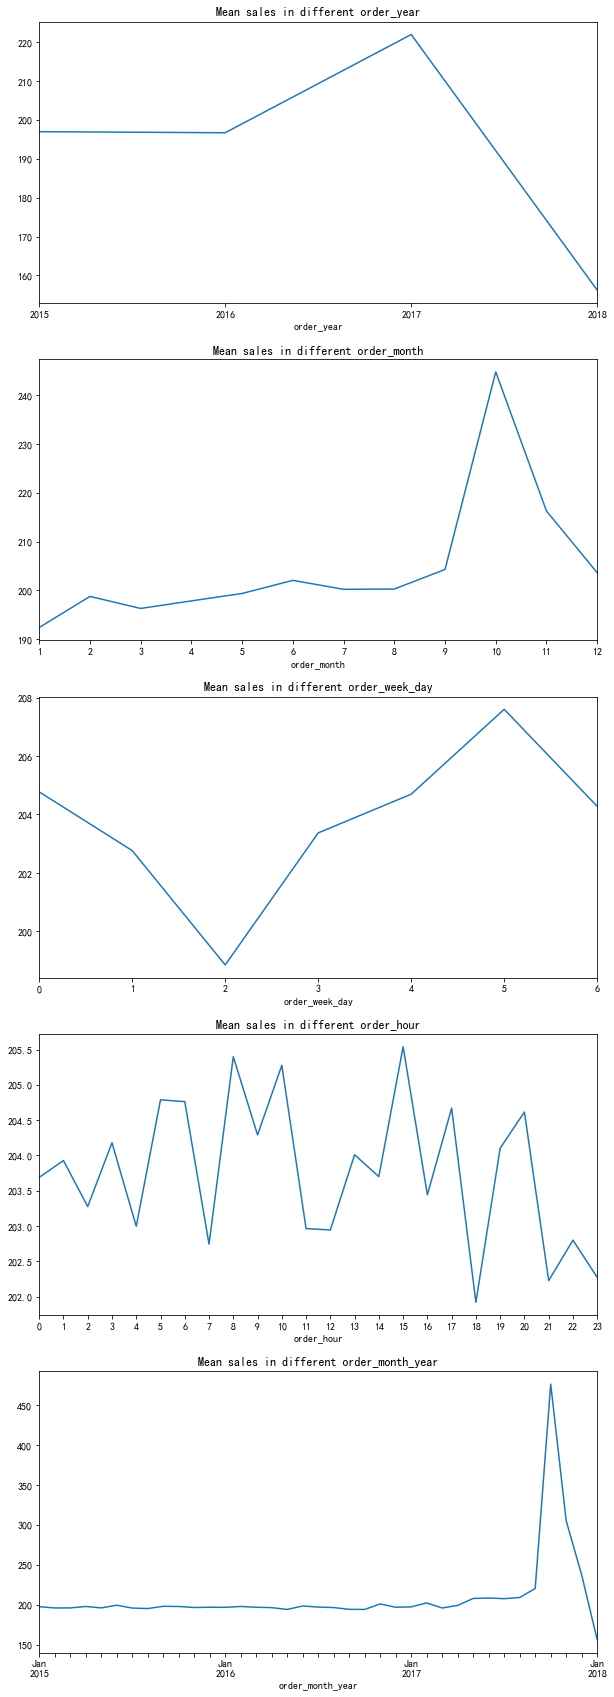

In [99]:
time_columns = ['order_year', 'order_month', 'order_week_day', 'order_hour', 'order_month_year']
plt.figure(figsize=(10,30))
for i in range(len(time_columns)):
    temp = data.groupby(time_columns[i])['Sales'].mean()
    plt.subplot(len(time_columns), 1, i+1)
    temp.plot(title='Mean sales in different '+time_columns[i])
    plt.xticks(temp.index) # 防止显示浮点数
plt.show()    

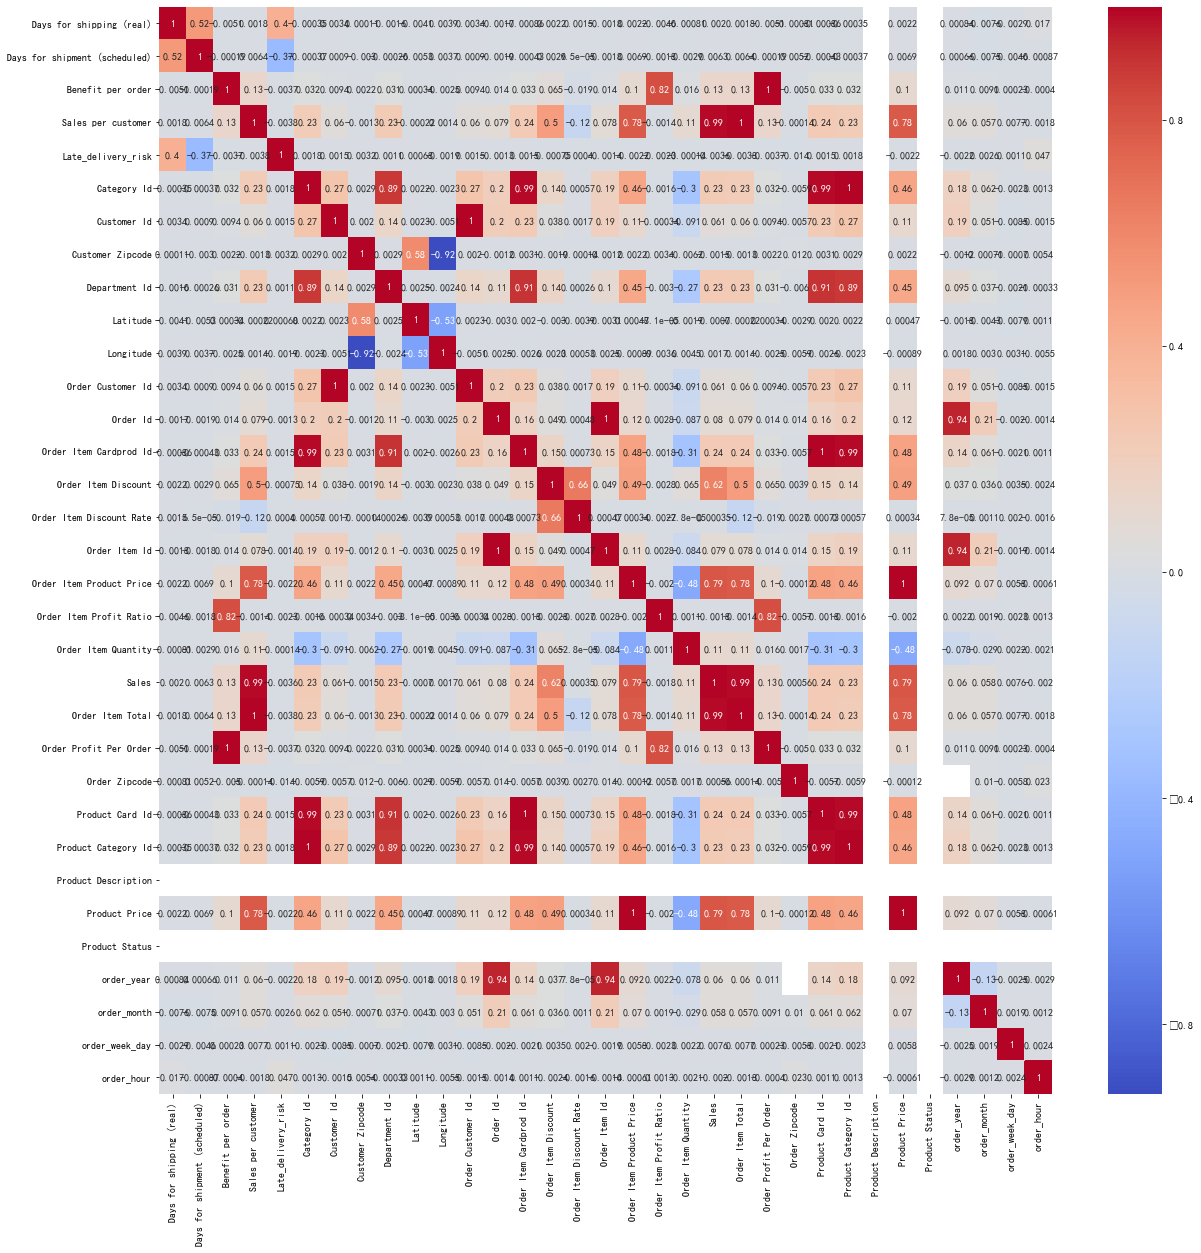

In [108]:
# 查看相关性
import seaborn as sns
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

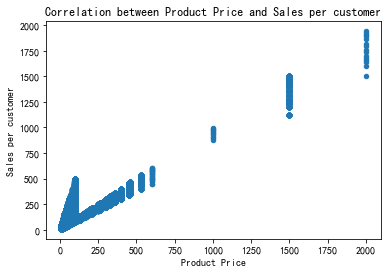

In [127]:
# 查看两个字段（Product Price和Sales per customer）之间的相关性
# 由上图结果可知，两者间的corr为0.78，较为正相关
data.plot(x='Product Price', y='Sales per customer', kind='scatter')
plt.xlabel('Product Price')
plt.ylabel('Sales per customer')
plt.title('Correlation between Product Price and Sales per customer')
plt.show()
# 直观上与corr相符